# Heart Failure Project

## Introduction:

"Cardiovascular diseases (CVDs) are the number 1 cause of death globally" (LARXEL, kaggle) and it is truly concerning how it is taking over many lives, like family members losing their love ones due to it, people needing to live their lives in hospitals, and so on. We hope to be able to use this opportunity to discover different factors that could lead to heart failure and building a model to predict those who are most in need and hopefully get them the medical attention they require. Our main focus of this project is to determine/answer the question: "which factors have a significant contribution towards heart failure?". The data we obtained consists of factors such as diabetes, high blood pressure, age, sex, whether someone smokes, and so on. Our goal is to use these factors as predictors to predict if someone should receive medical attention immediately or not. If predictions indicates death, it would suggest doctors to focus on this case immediately to prevent death, and if it indicates they are going to survive, then we would do precautions to prevent them from falling into the categories that might lead them to death. This dataset we gathered is from Kaggle, which was released by user LARXEL in 2020.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [3]:
read_data_from_link <- read_csv("https://raw.githubusercontent.com/KristenisHuaiyi/Data_Science_Project/main/data/heart_failure_clinical_records_dataset.csv.xls")
read_data_from_link

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,0,2060,1,60,0,742000,0.8,138,0,0,278,0
45,0,2413,0,38,0,140000,1.4,140,1,1,280,0
50,0,196,0,45,0,395000,1.6,136,1,1,285,0


In [4]:
#wrangling the data by selecting the predictors we would work with and 
#converting the response variable DEATH_EVENT to the factor datatype and renaming it to "survived"
#converting the predicting variables that has results 0 or 1 to the logical datatype so it shows as TRUE or FALSE

data_wrangled <- read_data_from_link |> 
            select(age, diabetes, ejection_fraction, serum_creatinine, high_blood_pressure, smoking, DEATH_EVENT) |>
            mutate(DEATH_EVENT = as_factor(DEATH_EVENT)) |>
            mutate(DEATH_EVENT = fct_recode(DEATH_EVENT, "Yes" = "0", "No" = "1")) |>
            rename("survived" = "DEATH_EVENT") |>
            mutate(diabetes = as.logical(diabetes)) |>
            mutate(high_blood_pressure = as.logical(high_blood_pressure)) |>
            mutate(smoking = as.logical(smoking))    

data_wrangled

age,diabetes,ejection_fraction,serum_creatinine,high_blood_pressure,smoking,survived
<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>,<fct>
75,FALSE,20,1.9,TRUE,FALSE,No
55,FALSE,38,1.1,FALSE,FALSE,No
65,FALSE,20,1.3,FALSE,TRUE,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,TRUE,60,0.8,FALSE,FALSE,Yes
45,FALSE,38,1.4,FALSE,TRUE,Yes
50,FALSE,45,1.6,FALSE,TRUE,Yes


In [5]:
#set the random seed in R
set.seed(1)

#split the data into training set and testing set
heart_split <- initial_split(data_wrangled, prop = 0.75, strata = survived)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train
heart_test

age,diabetes,ejection_fraction,serum_creatinine,high_blood_pressure,smoking,survived
<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>,<fct>
75,FALSE,20,1.9,TRUE,FALSE,No
55,FALSE,38,1.1,FALSE,FALSE,No
90,FALSE,40,2.1,TRUE,TRUE,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,TRUE,38,1.1,TRUE,TRUE,Yes
55,FALSE,38,1.2,FALSE,FALSE,Yes
45,TRUE,60,0.8,FALSE,FALSE,Yes


age,diabetes,ejection_fraction,serum_creatinine,high_blood_pressure,smoking,survived
<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>,<fct>
65,FALSE,20,1.3,FALSE,TRUE,No
50,FALSE,20,1.9,FALSE,FALSE,No
65,TRUE,20,2.7,FALSE,FALSE,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮
60,FALSE,35,1.4,FALSE,FALSE,Yes
45,FALSE,38,1.4,FALSE,TRUE,Yes
50,FALSE,45,1.6,FALSE,TRUE,Yes


In [6]:
#summarize values for subgroups "Survived" and "Died" within the training data set
train_summarize <- heart_train |> 
                   group_by(survived) |>
                   summarise(count = n())
train_summarize

survived,count
<fct>,<int>
Yes,152
No,72


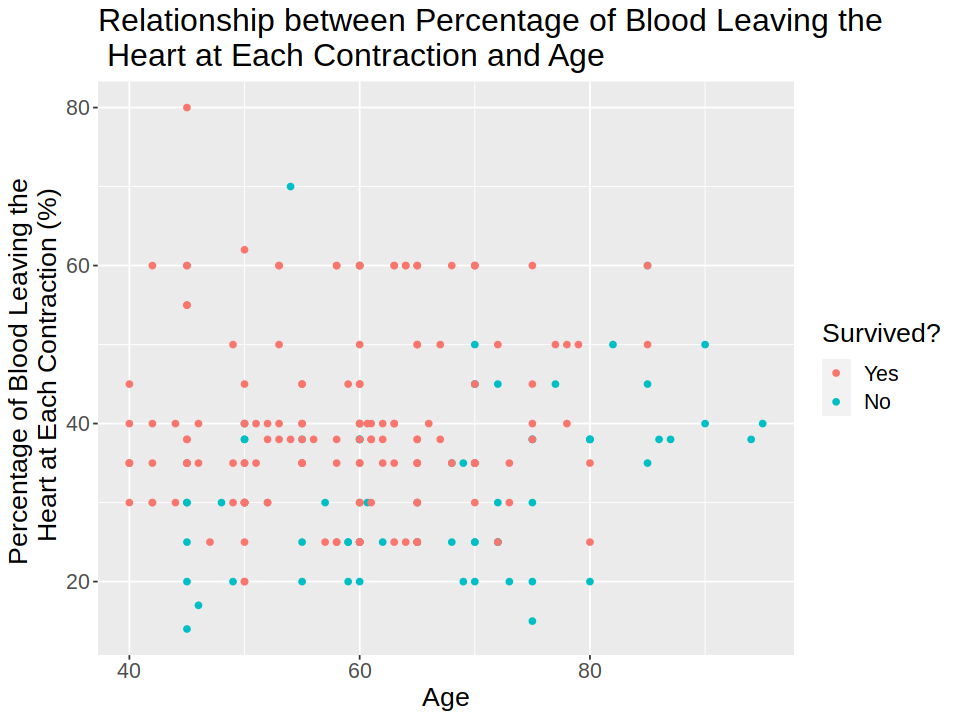

In [17]:
#set our graph to a proper size for visualization
options(repr.plot.width = 8, repr.plot.height = 6)

#visualize the data with a scatter plot
train_graph_point <- heart_train |>
            ggplot(aes(x = age, y = ejection_fraction, color = survived)) +
            geom_point() + 
            labs(x = "Age", 
                 y = "Percentage of Blood Leaving the \n Heart at Each Contraction (%)",
                 color = "Survived?") +
            ggtitle("Relationship between Percentage of Blood Leaving the \n Heart at Each Contraction and Age") +
            theme(text = element_text(size = 16))
train_graph_point

In [8]:
#preprocess data to be centered and scaled
#DEATH_EVENT is the response,
#age and ejection_fraction are predictors
heart_recipe <- recipe(survived ~ age + ejection_fraction, data = heart_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [9]:
#Here we want to do the preparation for finding the best K, so we first apply cross-validation. 
#We split training data to 5 validation set.
heart_vfold <- vfold_cv(heart_train, v = 5, strata = survived)

knn_tune <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_results <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(knn_tune) |>
                tune_grid(resamples = heart_vfold, grid = 5) |>
                collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.7098814,5,0.01913427,Preprocessor1_Model1
3,roc_auc,binary,0.7304531,5,0.03953023,Preprocessor1_Model1
5,accuracy,binary,0.7274704,5,0.01178088,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.7709140,5,0.03686067,Preprocessor1_Model3
13,accuracy,binary,0.7454545,5,0.01165254,Preprocessor1_Model4
13,roc_auc,binary,0.7590323,5,0.03720140,Preprocessor1_Model4


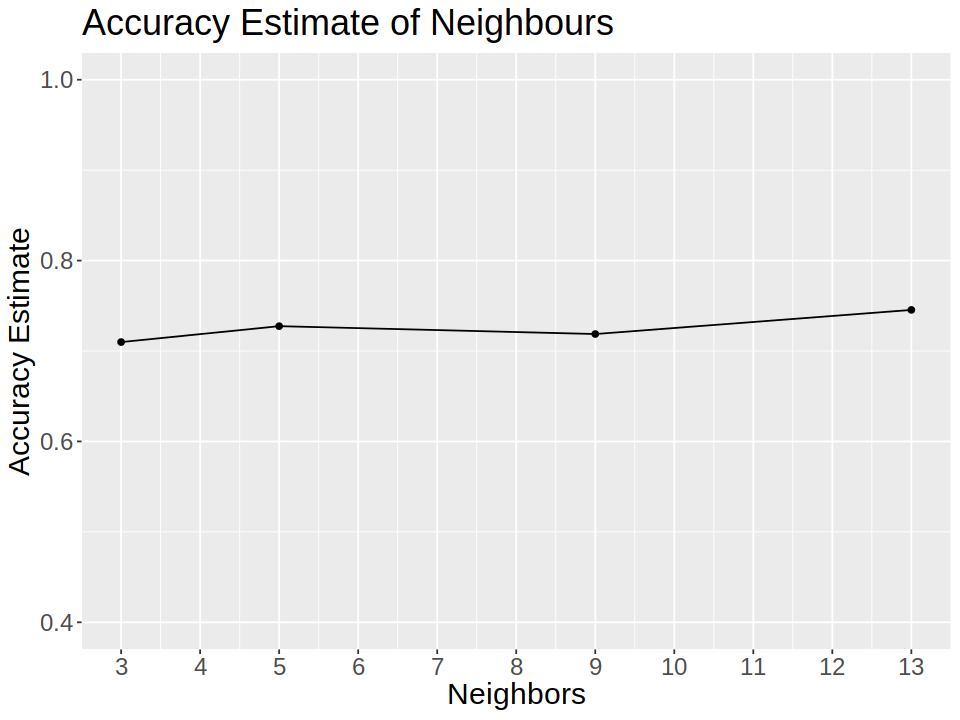

In [18]:
accuracies <- knn_results |>
            filter(.metric == "accuracy")

#visualize the neighbors versus accuracy estimate, therefore, we can find the most optimal K value.
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    ggtitle("Accuracy Estimate of Neighbours") +
                    scale_x_continuous(breaks = seq(0, 20, by = 1)) +
                    scale_y_continuous(limits = c(0.4, 1.0)) +
                    theme(text = element_text(size = 18))
accuracy_versus_k

In [11]:
#Now that we have explored our data, separated the data into training and testing sets, 
#We applied cross-validation to choose the best k, whcih is 9, so we can now build our final model.

#specification
heart_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")

#fit the model
heart_final_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_final_spec) |>
  fit(heart_train)

In [12]:
#Use final model to predict on the heart test dataset
heart_failure_predictions <- predict(heart_final_fit, heart_test) |>
        bind_cols(heart_test)

#Report the accuracy of our model
heart_metrics <- heart_failure_predictions |>
        metrics(truth = survived, estimate = .pred_class)

#Report the confusion matrix
heart_conf_mat <- heart_failure_predictions |>
        conf_mat(truth = survived, estimate = .pred_class)

heart_failure_predictions
heart_metrics
heart_conf_mat

.pred_class,age,diabetes,ejection_fraction,serum_creatinine,high_blood_pressure,smoking,survived
<fct>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>,<fct>
No,65,FALSE,20,1.3,FALSE,TRUE,No
No,50,FALSE,20,1.9,FALSE,FALSE,No
No,65,TRUE,20,2.7,FALSE,FALSE,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yes,60,FALSE,35,1.4,FALSE,FALSE,Yes
Yes,45,FALSE,38,1.4,FALSE,TRUE,Yes
Yes,50,FALSE,45,1.6,FALSE,TRUE,Yes


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7466667
kap,binary,0.3537415


          Truth
Prediction Yes No
       Yes  46 14
       No    5 10

As the accuracy report shows, our model get about 74.7% correct and fail to predict correctly for 35.4%. Therefore, we can further use more data set to train our model.